In [1]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout, Activation,BatchNormalization,MaxPool2D,Concatenate,Flatten, Lambda
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.applications import VGG19

print(tf.__version__)

/var/folders/q_/lwblb1qs4ms386qzk_239jqc0000gn/T/ipykernel_21853/197672952.py:3: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import ndimage, misc


2.15.1


In [2]:

# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/high_res' 
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '/Users/kunalnarwani/Desktop/Thesis/super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))


validation_high_image = high_img[700:810]
validation_low_image = low_img[700:810]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[810:]
test_low_image = low_img[810:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


100%|██████████| 855/855 [00:01<00:00, 528.78it/s]


Shape of test images: (45, 256, 256, 3)
Shape of validation images: (110, 256, 256, 3)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import Model, Input
from keras.saving import register_keras_serializable

@register_keras_serializable(package="resize")
class ResizeByScale(tf.keras.layers.Layer):
    def __init__(self, scale, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.scale = float(scale); self.method = method; self.antialias = antialias
    def call(self, x):
        x_dtype = x.dtype
        h = tf.shape(x)[1]; w = tf.shape(x)[2]
        nh = tf.cast(tf.round(tf.cast(h, tf.float32) * self.scale), tf.int32)
        nw = tf.cast(tf.round(tf.cast(w, tf.float32) * self.scale), tf.int32)
        y = tf.image.resize(tf.cast(x, tf.float32), [nh, nw], method=self.method, antialias=self.antialias)
        return tf.cast(y, x_dtype)
    def get_config(self):
        return {"scale": self.scale, "method": self.method, "antialias": self.antialias, **super().get_config()}

@register_keras_serializable(package="resize")
class ResizeToMatch(tf.keras.layers.Layer):
    def __init__(self, method="bilinear", antialias=True, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.method = method; self.antialias = antialias
    def call(self, inputs):
        x, ref = inputs
        target = tf.shape(ref)[1:3]
        y = tf.image.resize(tf.cast(x, tf.float32), target, method=self.method, antialias=self.antialias)
        return tf.cast(y, x.dtype)
    def get_config(self):
        return {"method": self.method, "antialias": self.antialias, **super().get_config()}

def conv_block(inputs, nf):
    # LayerNorm is more stable than BN for very small batches
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(inputs)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    x = L.Conv2D(nf, 3, padding="same", use_bias=True)(x)
    x = L.LayerNormalization(axis=-1)(x); x = L.Activation("relu")(x)
    return x

DOWNSCALE = 0.6
down     = ResizeByScale(DOWNSCALE, method="bilinear", antialias=True, name="enc_down")
up_to    = ResizeToMatch(method="bilinear", antialias=True, name="dec_up")

def encoder_block(inputs, nf):
    x = conv_block(inputs, nf)
    p = down(x)
    return x, p

def decoder_block(inputs, skip_features, nf):
    x = up_to([inputs, skip_features])
    x = L.Conv2D(nf, 3, padding='same', activation='relu')(x)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, nf)
    return x


@register_keras_serializable(package="upsample")
class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, r=2, **kwargs):
        super().__init__(**kwargs); self.r = int(r)
    def call(self, x): return tf.nn.depth_to_space(x, block_size=self.r)
    def get_config(self): return {"r": self.r, **super().get_config()}


# Sub-pixel (pixel-shuffle) upsampling for final 2x  (no Lambda anymore)
def subpixel_block(x, r=2, nf=64):
    x = L.Conv2D(nf * (r*r), 3, padding='same')(x)
    x = PixelShuffle(r=r, name=f"pixel_shuffle_x{r}")(x)
    x = L.Activation('relu')(x)
    return x

custom_objects = {
    "ResizeByScale": ResizeByScale,
    "ResizeToMatch": ResizeToMatch,
    "PixelShuffle": PixelShuffle,
}



In [4]:
# ================= Evaluation  =================
import numpy as np
import tensorflow as tf
from keras.saving import load_model
from keras.saving import load_model

BATCH_SIZE = 8

model_path = "/Users/kunalnarwani/Desktop/Thesis/super-resolution/models/best_by_val_loss_0.6.keras"
model = tf.keras.models.load_model(
    model_path,
    custom_objects=custom_objects,
    compile=False,
    safe_mode=False,   # key change from vinillia which permit Lambda deserialization
)

def make_eval_ds(lr_np, hr_np, batch_size=BATCH_SIZE):
    """Build a non-repeating dataset from numpy arrays already in memory."""
    ds = tf.data.Dataset.from_tensor_slices((lr_np, hr_np))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def evaluate_dataset(ds, model):
    all_psnr, all_ssim, all_msssim = [], [], []
    n_images = 0

    for lr_b, hr_b in ds:

        pred_b = model(lr_b, training=False)

        if pred_b.shape[1:3] != hr_b.shape[1:3]:
            pred_b = tf.image.resize(pred_b, size=hr_b.shape[1:3], method="bicubic")

        hr_tf   = tf.cast(hr_b, tf.float32)
        pred_tf = tf.cast(tf.clip_by_value(pred_b, 0.0, 1.0), tf.float32)

        psnr_b  = tf.image.psnr(hr_tf, pred_tf, max_val=1.0)              
        ssim_b  = tf.image.ssim(hr_tf, pred_tf, max_val=1.0)              
        mssim_b = tf.image.ssim_multiscale(hr_tf, pred_tf, max_val=1.0)   

        all_psnr.append(psnr_b.numpy())
        all_ssim.append(ssim_b.numpy())
        all_msssim.append(mssim_b.numpy())
        n_images += int(hr_b.shape[0])

    def mean_std(x):
        x = np.concatenate(x, axis=0) if isinstance(x, list) else np.asarray(x)
        return float(np.mean(x)), float(np.std(x))

    m_psnr, s_psnr     = mean_std(all_psnr)
    m_ssim, s_ssim     = mean_std(all_ssim)
    m_msssim, s_msssim = mean_std(all_msssim)

    return n_images, (m_psnr, s_psnr), (m_ssim, s_ssim), (m_msssim, s_msssim)

# ------ Validation ------
val_ds = make_eval_ds(validation_low_image, validation_high_image, BATCH_SIZE)
n_val, (mP, sP), (mS, sS), (mMS, sMS) = evaluate_dataset(val_ds, model)

print(f"[Validation] images: {n_val}")
print(f" PSNR    : {mP:.4f} ± {sP:.4f} dB")
print(f" SSIM    : {mS:.4f} ± {sS:.4f}")
print(f" MS-SSIM : {mMS:.4f} ± {sMS:.4f}")


[Validation] images: 110
 PSNR    : 31.0072 ± 3.4615 dB
 SSIM    : 0.9132 ± 0.0479
 MS-SSIM : 0.9942 ± 0.0034


# U-Net (v0.6) Training Summary

Job: unet-train · Node: cn47 · TF: 2.15.1 (XLA on) · GPU: /physical_device:GPU:0
Wall time: 1h51m54s (early stop @ 39 epochs, best epoch 29)

Data
	•	Resolution: 256×256×3
	•	Splits: train 700, val 110, test 45

Model (your 0.6 architecture)
	•	Name: U-Net_SR_same_size · Params: 34.60M
	•	Norm: LayerNorm (vs BN in vanilla)
	•	Down/Up: custom resize layers — ResizeByScale in encoder (≈0.6 per stage: 256→154→92→55→33), ResizeToMatch in decoder
	•	Head: residual RGB (input + residual_rgb via Lambda)
	•	Checkpoint (best val_loss):
/home/knarwani/thesis/super-resolution/models/best_by_val_loss_0.6.keras

Training
	•	Loss trajectory (val): steadily ↓ from 29.96 → 18.48 (ep29 best), then plateaus
	•	Per-epoch time: ~167–176 s (first epoch ~210 s due to compile)

Final Validation (110 imgs)
	•	PSNR: 31.01 ± 3.46 dB
	•	SSIM: 0.9132 ± 0.0479
	•	MS-SSIM: 0.9942 ± 0.0034

Notes
	•	Compared to vanilla, this run achieves ~+1.65 dB higher val PSNR (29.36 → 31.01 dB) with similar SSIM.


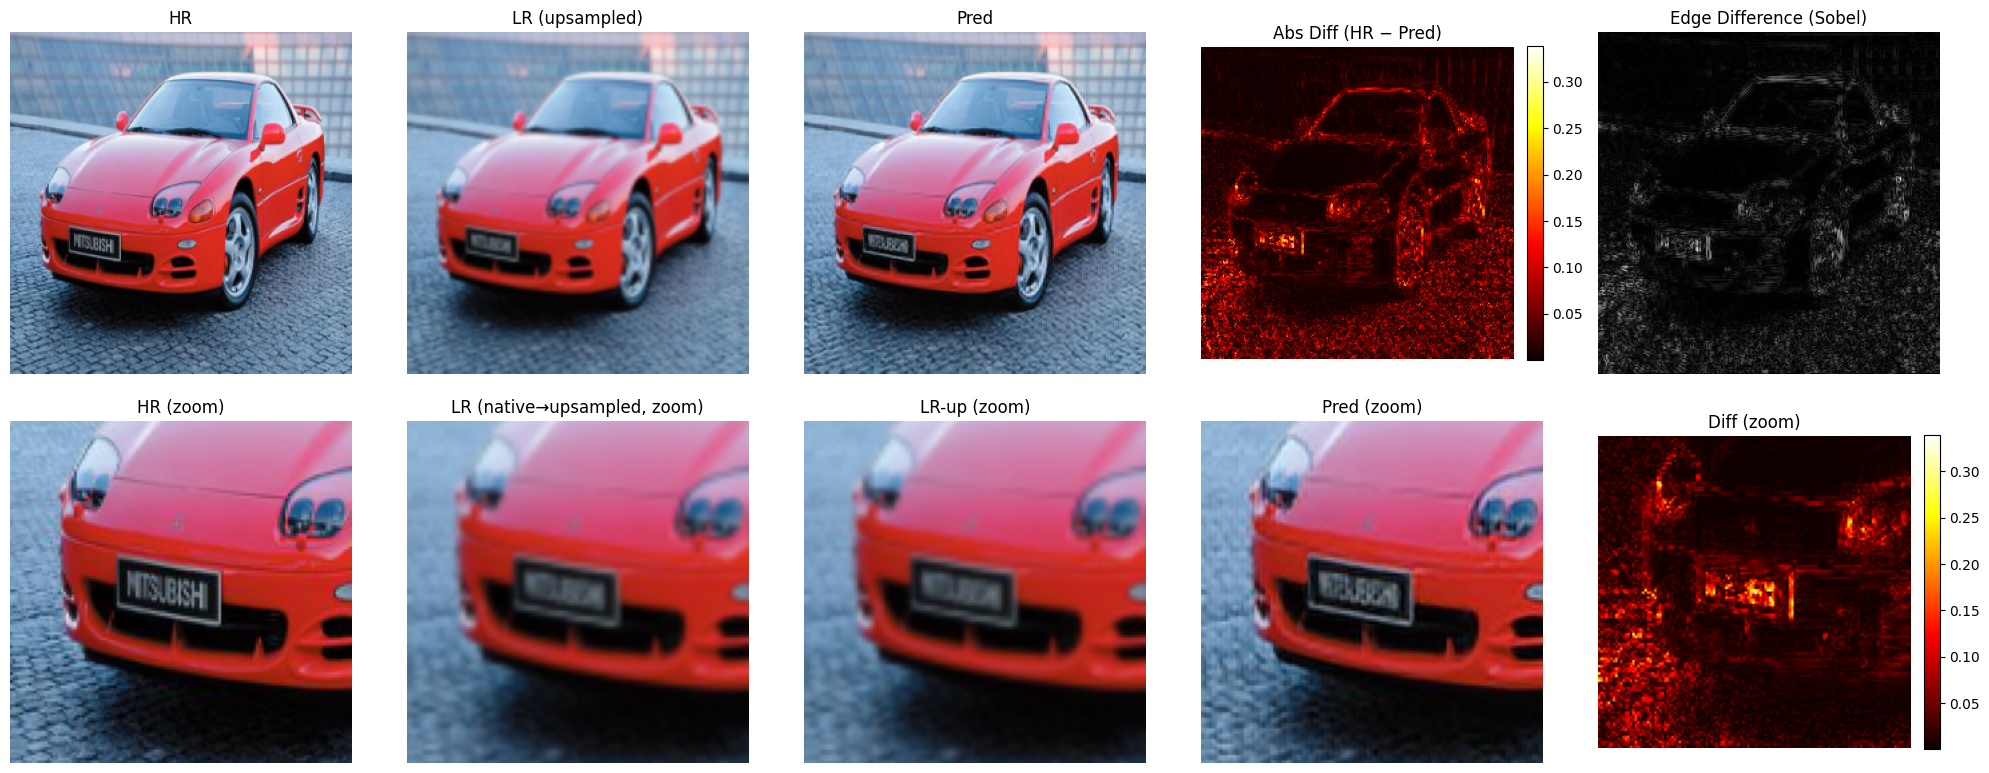

In [7]:
# ========== VISUAL CHECK ===========
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

def visualize_example(model, lr_np, hr_np, index=0):
    # grab one sample
    lr_i = lr_np[index].astype(np.float32)   
    hr_i = hr_np[index].astype(np.float32)   

    # forward pass on a batch of 1
    pred_i = model.predict(lr_i[None, ...], verbose=0)[0]
    pred_i = pred_i.astype(np.float32)       

    H, W = hr_i.shape[:2]

    # If output size differs from HR, resize
    if pred_i.shape[:2] != (H, W):
        pred_i = cv2.resize(pred_i, (W, H), interpolation=cv2.INTER_CUBIC).astype(np.float32)

    # For fair side-by-side
    if lr_i.shape[:2] != (H, W):
        lr_up = cv2.resize(lr_i, (W, H), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    else:
        lr_up = lr_i

    # Clip to [0,1] for display (keeps float32)
    hr_i   = np.clip(hr_i,   0.0, 1.0).astype(np.float32)   
    lr_up  = np.clip(lr_up,  0.0, 1.0).astype(np.float32)   
    pred_i = np.clip(pred_i, 0.0, 1.0).astype(np.float32)   

    # --- 1) Absolute difference heatmap (HR vs Pred) ---
    diff = np.abs(hr_i - pred_i).astype(np.float32)        
    diff_gray = diff.mean(axis=2).astype(np.float32)        

    # --- 2) Auto-zoom around the largest error ---
    def crop_around(yx, size, H, W):
        cy, cx = yx
        hh = size // 2
        y1 = max(0, cy - hh); y2 = min(H, cy + hh)
        x1 = max(0, cx - hh); x2 = min(W, cx + hh)
        return slice(y1, y2), slice(x1, x2)

    maxy, maxx = np.unravel_index(np.argmax(diff_gray), diff_gray.shape)
    crop_size = min(128, min(H, W))
    ys, xs = crop_around((maxy, maxx), crop_size, H, W)

    hr_crop   = hr_i[ys, xs].astype(np.float32)            
    pred_crop = pred_i[ys, xs].astype(np.float32)           
    diff_crop = diff_gray[ys, xs].astype(np.float32)       

    # --- 2a) LR crops (native and upsampled to crop size) ---
    h_lr, w_lr = lr_i.shape[:2]
    sy = h_lr / float(H)
    sx = w_lr / float(W)

    lr_y1 = int(round(ys.start * sy)); lr_y2 = int(round(ys.stop * sy))
    lr_x1 = int(round(xs.start  * sx)); lr_x2 = int(round(xs.stop  * sx))

    lr_y1 = np.clip(lr_y1, 0, max(0, h_lr - 1))
    lr_y2 = np.clip(max(lr_y2, lr_y1 + 1), 1, h_lr)
    lr_x1 = np.clip(lr_x1, 0, max(0, w_lr - 1))
    lr_x2 = np.clip(max(lr_x2, lr_x1 + 1), 1, w_lr)

    lr_native_crop = lr_i[lr_y1:lr_y2, lr_x1:lr_x2].astype(np.float32)   
    lr_native_crop_up = cv2.resize(
        lr_native_crop, (hr_crop.shape[1], hr_crop.shape[0]),
        interpolation=cv2.INTER_NEAREST
    ).astype(np.float32)                                                  
    lr_up_crop = lr_up[ys, xs].astype(np.float32)                         

    # --- 3) Edge maps (Sobel) + edge difference (full image) ---
    def to_gray_u8(x):
        g = (0.299*x[...,0] + 0.587*x[...,1] + 0.114*x[...,2])
        return np.clip(g*255.0, 0, 255).astype(np.uint8)

    hr_g   = to_gray_u8(hr_i)
    pred_g = to_gray_u8(pred_i)

    sobelx_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 1, 0, ksize=3)
    sobely_hr = cv2.Sobel(hr_g,   cv2.CV_32F, 0, 1, ksize=3)
    edges_hr  = np.hypot(sobelx_hr, sobely_hr).astype(np.float32)         

    sobelx_pr = cv2.Sobel(pred_g, cv2.CV_32F, 1, 0, ksize=3)
    sobely_pr = cv2.Sobel(pred_g, cv2.CV_32F, 0, 1, ksize=3)
    edges_pr  = np.hypot(sobelx_pr, sobely_pr).astype(np.float32)        

    edge_diff = np.abs(edges_hr - edges_pr).astype(np.float32)            

    def norm01(x):
        x = x.astype(np.float32)
        m, M = np.min(x), np.max(x)
        return (x - m) / (M - m + 1e-8)

    edges_hr_n  = norm01(edges_hr)
    edges_pr_n  = norm01(edges_pr)
    edge_diff_n = norm01(edge_diff)

    # --- Plot grid ---
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    axs[0,0].imshow(hr_i);     axs[0,0].set_title("HR");                 axs[0,0].axis("off")
    axs[0,1].imshow(lr_up);    axs[0,1].set_title("LR (upsampled)");     axs[0,1].axis("off")
    axs[0,2].imshow(pred_i);   axs[0,2].set_title("Pred");               axs[0,2].axis("off")
    im = axs[0,3].imshow(diff_gray, cmap="hot")
    axs[0,3].set_title("Abs Diff (HR − Pred)"); axs[0,3].axis("off")
    axs[0,4].imshow(edge_diff_n, cmap="gray")
    axs[0,4].set_title("Edge Difference (Sobel)"); axs[0,4].axis("off")

    axs[1,0].imshow(hr_crop);             axs[1,0].set_title("HR (zoom)");                    axs[1,0].axis("off")
    axs[1,1].imshow(lr_native_crop_up);   axs[1,1].set_title("LR (native→upsampled, zoom)");  axs[1,1].axis("off")
    axs[1,2].imshow(lr_up_crop);          axs[1,2].set_title("LR-up (zoom)");                 axs[1,2].axis("off")
    axs[1,3].imshow(pred_crop);           axs[1,3].set_title("Pred (zoom)");                  axs[1,3].axis("off")
    im2 = axs[1,4].imshow(diff_crop, cmap="hot")
    axs[1,4].set_title("Diff (zoom)");    axs[1,4].axis("off")

    fig.colorbar(im,  ax=axs[0,3], fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=axs[1,4], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Example call
visualize_example(model, validation_low_image, validation_high_image, index=1)